=== 총 Entity 개수: 16 ===
{'Animal': 0, 'Cat': 1, 'Dog': 2, 'Flower': 3, 'Human': 4, 'Living Thing': 5, 'Lizard': 6, 'Mammal': 7, 'Oak': 8, 'Pine': 9, 'Plant': 10, 'Reptile': 11, 'Rose': 12, 'Snake': 13, 'Tree': 14, 'Tulip': 15}

=== 생성된 학습 데이터 (Triples) ===
       Head Relation          Tail
0    Animal      IsA  Living Thing
1     Plant      IsA  Living Thing
2    Mammal      IsA        Animal
3   Reptile      IsA        Animal
4    Flower      IsA         Plant
5      Tree      IsA         Plant
6       Dog      IsA        Mammal
7       Cat      IsA        Mammal
8     Human      IsA        Mammal
9     Snake      IsA       Reptile
10   Lizard      IsA       Reptile
11     Rose      IsA        Flower
12    Tulip      IsA        Flower
13     Pine      IsA          Tree
14      Oak      IsA          Tree


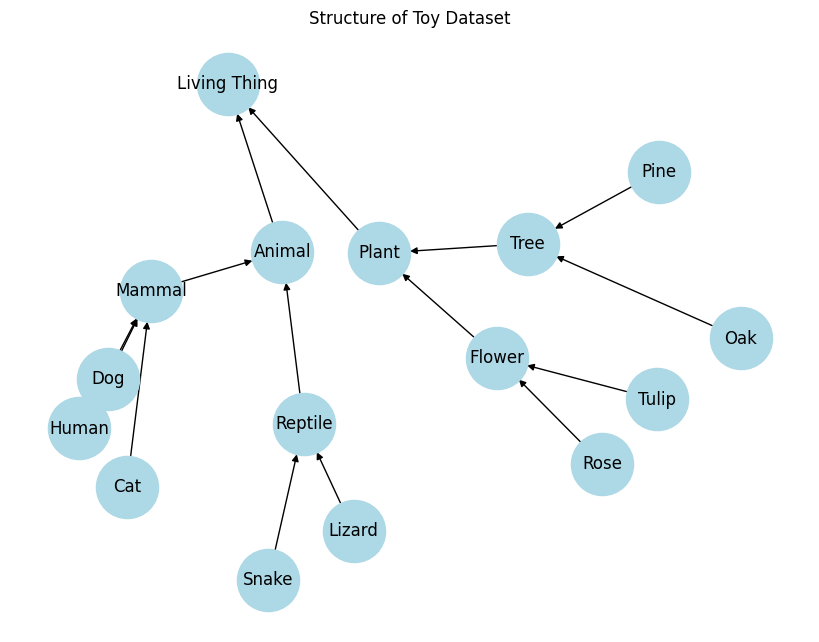

In [13]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def generate_toy_hierarchy():
    """
    3단계 깊이의 계층 구조 데이터를 생성합니다.
    Level 0: Living Thing (생물)
    Level 1: Animal, Plant (동물, 식물)
    Level 2: Mammal, Reptile, Flower, Tree (포유류, 파충류 등)
    Level 3: Dog, Cat, Snake, Rose, Pine (구체적 대상)
    """
    
    # 1. 계층 구조 정의 (Parent -> Children)
    hierarchy = {
        'Living Thing': ['Animal', 'Plant'],
        
        'Animal': ['Mammal', 'Reptile'],
        'Plant': ['Flower', 'Tree'],
        
        'Mammal': ['Dog', 'Cat', 'Human'],
        'Reptile': ['Snake', 'Lizard'],
        'Flower': ['Rose', 'Tulip'],
        'Tree': ['Pine', 'Oak']
    }

    triples = []
    
    # 2. Triple 생성 (Child, IsA, Parent)
    # Box Embedding에서는 보통 (Head, Relation, Tail)을 사용
    # 여기서는 "Child는 Parent의 부분집합이다"를 표현
    for parent, children in hierarchy.items():
        for child in children:
            # (Subject, Relation, Object)
            triples.append((child, 'IsA', parent))
            
            # Transitive Data (선택 사항): 
            # 학습을 돕기 위해 'Dog IsA Animal' 같은 건너뛰는 관계도 추가할 수 있음
            # 하지만 Box Embedding의 강력함을 보려면, 직접적인 관계만 주고
            # 건너뛰는 관계를 잘 추론하는지 보는 것이 좋음. (일단은 생략)

    return triples, hierarchy

# 데이터 생성 실행
toy_triples, toy_adj = generate_toy_hierarchy()

# 3. 데이터 확인 및 ID 매핑 (문자열 -> 숫자)
entities = sorted(list(set([t[0] for t in toy_triples] + [t[2] for t in toy_triples])))
entity2id = {e: i for i, e in enumerate(entities)}

print(f"=== 총 Entity 개수: {len(entities)} ===")
print(entity2id)
print("\n=== 생성된 학습 데이터 (Triples) ===")
df = pd.DataFrame(toy_triples, columns=['Head', 'Relation', 'Tail'])
print(df)

# 4. (참고용) 데이터 구조 시각화 (트리 구조 확인)
# 실제 Box 학습 전, 데이터가 어떻게 생겼는지 확인하는 용도
plt.figure(figsize=(8, 6))
G = nx.DiGraph()
G.add_edges_from([(t[0], t[2]) for t in toy_triples])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrows=True)
plt.title("Structure of Toy Dataset")
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BoxEmbeddingModel(nn.Module):
    def __init__(self, num_entities, embedding_dim=2, volume_temp=1.0):
        super().__init__()
        
        self.num_entities = num_entities
        self.embedding_dim = embedding_dim
        self.volume_temp = volume_temp  # Gumbel-Softmax 등에 쓰이는 온도 상수 (여기선 단순화)

        # 1. Center Embedding (위치)
        # 범위: [-1, 1] 정도에서 랜덤 초기화
        self.center_embeddings = nn.Embedding(num_entities, embedding_dim)
        nn.init.uniform_(self.center_embeddings.weight, -1.0, 1.0)

        # 2. Offset Embedding (크기/너비)
        # 중요: 박스 크기는 무조건 양수여야 함.
        # 초기화: 너무 작으면(0에 수렴) 점이 되고, 너무 크면 학습이 안 됨.
        # 0.1 ~ 0.5 사이의 값을 갖도록 초기화 유도
        self.offset_embeddings = nn.Embedding(num_entities, embedding_dim)
        nn.init.uniform_(self.offset_embeddings.weight, 0.1, 0.5)

    def get_boxes(self, indices):
        """
        Entity ID를 받아 [Min_coord, Max_coord]를 반환
        Min = Center - Offset
        Max = Center + Offset
        """
        centers = self.center_embeddings(indices)
        
        # Offset은 항상 양수여야 하므로 Softplus (Log(1+exp(x))) 통과
        # 그냥 abs()를 쓰면 0에서 미분 불가능 점이 생겨 학습이 불안정할 수 있음
        offsets = F.softplus(self.offset_embeddings(indices))
        
        min_coords = centers - offsets
        max_coords = centers + offsets
        
        return min_coords, max_coords, centers, offsets

    def forward(self, child_indices, parent_indices):
        """
        학습 목표: Child Box가 Parent Box 안에 들어가야 한다.
        Loss = "Child가 Parent 밖으로 삐져나온 정도"
        """
        # 1. 박스 좌표 추출
        c_min, c_max, _, _ = self.get_boxes(child_indices) # Child
        p_min, p_max, _, _ = self.get_boxes(parent_indices) # Parent
        
        # 2. 포함 관계 위반(Violation) 계산 (핵심 수식)
        # Child의 Min은 Parent의 Min보다 커야 함 (안쪽에 있어야 하니까)
        # -> 위반: Parent_Min - Child_Min > 0 인 경우
        # relu함수는 element-wise하게 작동함.
        violation_min = F.relu(p_min - c_min)
        
        # Child의 Max는 Parent의 Max보다 작아야 함
        # -> 위반: Child_Max - Parent_Max > 0 인 경우
        violation_max = F.relu(c_max - p_max)
        
        # 3. Loss 합산 (L1 Norm or L2 Norm)
        # 삐져나온 거리가 클수록 페널티
        intersection_loss = torch.norm(violation_min, p=2, dim=-1) + \
                            torch.norm(violation_max, p=2, dim=-1)
        
        return intersection_loss.mean()

    def get_all_boxes_for_visualization(self):
        """시각화를 위해 모든 박스 좌표 반환 (Detach)"""
        with torch.no_grad():
            centers = self.center_embeddings.weight.data
            offsets = F.softplus(self.offset_embeddings.weight.data)
            
            min_coords = centers - offsets
            max_coords = centers + offsets
            
            return min_coords.cpu().numpy(), max_coords.cpu().numpy()